In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/KXBTCD-25MAY1323.csv', delimiter=',')

In [4]:
data.head()

,timestamp,product,price,strike,expiration_time,bid_1_price,bid_1_quantity,bid_2_price,bid_2_quantity,bid_3_price,...,ask_1_price,ask_1_quantity,ask_2_price,ask_2_quantity,ask_3_price,ask_3_quantity,ask_4_price,ask_4_quantity,ask_5_price,ask_5_quantity
0,2025-05-14 02:03:15,BRTI,103621.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-14 02:03:15,KXBTCD-25MAY1323-T102749.99,NaN,102750.0,2025-05-14 03:05:00+00:00,82.0,3000.0,61.0,600.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-05-14 02:03:15,KXBTCD-25MAY1323-T102999.99,NaN,103000.0,2025-05-14 03:05:00+00:00,92.0,488.0,79.0,9.0,78.0,...,97.0,600.0,98.0,80750.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-05-14 02:03:15,KXBTCD-25MAY1323-T103999.99,NaN,104000.0,2025-05-14 03:05:00+00:00,11.0,544.0,3.0,80000.0,NaN,...,16.0,850.0,17.0,2400.0,22.0,14.0,24.0,30.0,27.0,3000.0
4,2025-05-14 02:03:15,KXBTCD-25MAY1323-T103499.99,NaN,103500.0,2025-05-14 03:05:00+00:00,62.0,2850.0,61.0,250.0,55.0,...,65.0,14.0,67.0,250.0,68.0,30.0,88.0,9.0,89.0,2600.0


In [12]:
import matplotlib.pyplot as plt
import datetime

In [15]:
datetime.datetime.fromisoformat('2025-05-14 02:03:15')

datetime.datetime(2025, 5, 14, 2, 3, 15)

In [267]:
brti_prices = data[data['product'] == 'BRTI'][['timestamp', 'price']]

brti_prices.reset_index(drop=True, inplace=True)

brti_prices['timestamp'] = brti_prices.apply(lambda x: datetime.datetime.fromisoformat(x['timestamp']), axis=1)

start_time = brti_prices['timestamp'].min()

# turn timestamp into seconds from start_time
brti_prices['seconds'] = brti_prices['timestamp'].apply(lambda x: (x - start_time).total_seconds()).bfill()
# convert to seconds

brti_prices['60s simple average'] = brti_prices['price'].rolling(60).mean().bfill()

window_size = 60

brti_prices['log_returns'] = pd.Series(np.log(brti_prices['price'])).diff()
brti_prices['vol_per_second'] = brti_prices['log_returns'].rolling(window_size).std().bfill()
brti_prices

,timestamp,price,seconds,60s simple average,log_returns,vol_per_second
0,2025-05-14 02:03:15,103621.92,0.0,103627.123500,NaN,0.000080
1,2025-05-14 02:03:16,103618.90,1.0,103627.123500,-2.914484e-05,0.000080
2,2025-05-14 02:03:17,103620.18,2.0,103627.123500,1.235288e-05,0.000080
3,2025-05-14 02:03:18,103620.23,3.0,103627.123500,4.825314e-07,0.000080
4,2025-05-14 02:03:21,103623.97,6.0,103627.123500,3.609269e-05,0.000080
...,...,...,...,...,...,...
2801,2025-05-14 03:00:11,103723.98,3416.0,103702.523667,2.603096e-05,0.000036
2802,2025-05-14 03:00:12,103723.95,3417.0,103702.714833,-2.892292e-07,0.000036
2803,2025-05-14 03:00:13,103723.08,3418.0,103702.893333,-8.387683e-06,0.000036
2804,2025-05-14 03:00:15,103722.19,3420.0,103703.156667,-8.580576e-06,0.000035


# GBM modelling

In [269]:
def gbm_model(price, sigma, start, end, mu=0.0, M=1000, strikes=[]):
    n = int(end-start)

    P0 = price 
    dt = 1

    # sim using np 
    St = np.exp(
        (mu - 0.5 * sigma ** 2) * dt 
        + sigma * np.sqrt(dt) * 
        np.random.normal(0, 1, (M, n)).T
    )

    # include array of 1's
    St = np.vstack([np.ones(M), St])

    # multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
    St = P0 * np.cumprod(St, axis=0)
    St.shape

    # get last 60 seconds of each sim
    last_60 = St[-60:, :]

    # take mean of last 60 seconds of each sim
    mean_last_60 = np.mean(last_60, axis=0)

    probs = []
    for strike in strikes:
        count = np.sum(mean_last_60 > strike)
        # calculate probability
        prob = count / M

    return probs

In [ ]:
from tqdm import tqdm

end = brti_prices['seconds'].max()
strikes = data['strike'].unique()[1:]

preds = []

for row in tqdm(brti_prices.iterrows()):
    price = row[1]['price']
    sigma = row[1]['vol_per_second']
    start = row[1]['seconds']
    timestamp = row[1]['timestamp']

    pred = gbm_model(price, sigma, start, end, mu=0.0, M=10000, strikes=strikes)
    preds.append(pred)



SyntaxError: positional argument follows keyword argument (3698253079.py, line 11)

In [270]:
mu = 0 # drift coefficient

# time in seconds
start = 0
end = 3422
n = int(end - start) # also equal to time in seconds

P0 = 103621.92 # initial price

# number of sims 
M = 10000

# volatility
sigma = 0.000036

## simulating GBM paths

In [274]:
# calculate each timestep
dt = 1 # every second

# sim using np 
St = np.exp(
    (mu - 0.5 * sigma ** 2) * dt 
    + sigma * np.sqrt(dt) * 
    np.random.normal(0, 1, (M, n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
St = P0 * np.cumprod(St, axis=0)
St.shape

# get last 60 seconds of each sim
last_60 = St[-60:, :]

# take mean of last 60 seconds of each sim
mean_last_60 = np.mean(last_60, axis=0)

for strike in data['strike'].unique():
    # count how many times the mean last 60 seconds is greater than the strike
    count = np.sum(mean_last_60 > strike)
    # calculate probability
    prob = count / M
    print(f"Strike: {strike}, Probability: {prob*100:.2f}%")

Strike: nan, Probability: 0.00%
Strike: 102750.0, Probability: 100.00%
Strike: 103000.0, Probability: 99.85%
Strike: 104000.0, Probability: 4.39%
Strike: 103500.0, Probability: 72.09%
Strike: 103750.0, Probability: 28.78%
Strike: 103250.0, Probability: 95.86%
Strike: 102500.0, Probability: 100.00%


Text(0, 0.5, 'Price ($)')

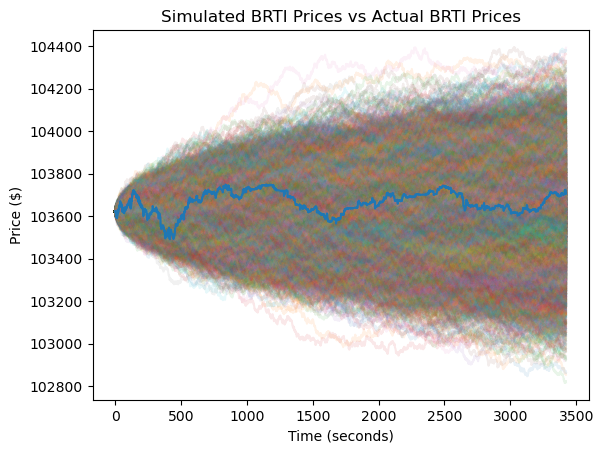

In [258]:
plt.plot(St, alpha=0.1)
plt.plot(brti_prices['seconds'], brti_prices['price'])
plt.title("Simulated BRTI Prices vs Actual BRTI Prices")
plt.xlabel("Time (seconds)")
plt.ylabel("Price ($)")

In [47]:
brti_prices['seconds'].max()

3422.0

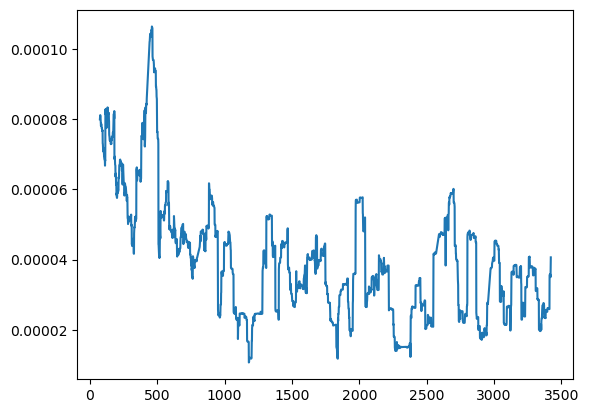

In [100]:
plt.plot(brti_prices['seconds'], brti_prices['vol_per_60_second'])

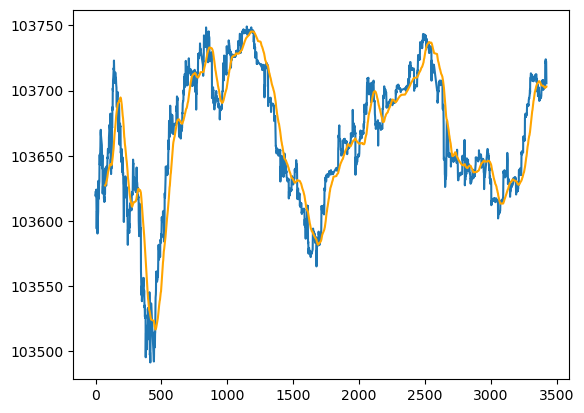

In [33]:
plt.plot(brti_prices['seconds'], brti_prices['price'])
plt.plot(brti_prices['seconds'], brti_prices['60s simple average'], c='orange')

In [25]:
data['strike'].unique(), data['product'].unique()

(array([    nan, 102750., 103000., 104000., 103500., 103750., 103250.,
        102500.]),
 array(['BRTI', 'KXBTCD-25MAY1323-T102749.99',
        'KXBTCD-25MAY1323-T102999.99', 'KXBTCD-25MAY1323-T103999.99',
        'KXBTCD-25MAY1323-T103499.99', 'KXBTCD-25MAY1323-T103749.99',
        'KXBTCD-25MAY1323-T103249.99', 'KXBTCD-25MAY1323-T102499.99'],
       dtype=object))